# Neurosymbolic Software Tutorial - Classification

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/near_demo_classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executable code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side as shown. `@TODO`
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.


## Outline
- Part 1: Data Exploration
    - We're going to define a function `datagen()` and plot trajectories generated with datagen.
    - **Exercise**: Before reading through the code, look at the trajectory plot and hypothesize what the underlying function might be. Write down what mathematical operators (`sin`, `pow`, `exp`, etc.) would be useful to discover the underlying function.
- Part 2: DSL Generation
    - We're going to formalize our intuition by writing a DSL. Write code for the DSL.
    - **Exercise**: Modify the DSL with the mathematical operators we wrote down earlier. 
- Part 3: Program Generation
    - We're going to use Neural guided search (NEAR) to search for the best-fit program in the DSL.
- Part 4: Program Inspection
    - We will render the program found by NEAR and inspect it's performance. 
    - **Exercise**: Inspect the program found after search. Try different hyperparamters.

## Part 1: Data Exploration
- Cell 1: Define `datagen()` and save data.
- Cell 2: Plot the saved data.
- Cell 3: Exercise

In [1]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np

import neurosym as ns
from neurosym.examples import near

IS_REGRESSION = False


def datagen(B, T, *, seed, is_regression=False):
    rng = np.random.RandomState(seed)
    # generates a numpy trajectory of shape
    #   X = (B, T, d_inp)
    # and a numpy target of shape
    #   Y = (B, T, 1)
    X = rng.rand(B, T, 2)

    X[:, 0, :] = 0
    for t in range(1, T):
        step = rng.randn(B, 2) * 0.1
        X[:, t, :] = X[:, t - 1, :] + step
    X = X.astype(np.float32)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    X = (X - 0.5) * 2
    if is_regression:
        # y = distance from origin of X
        Y = np.zeros((B, T, 1))
        Y = np.linalg.norm(X, axis=2, keepdims=True)
        Y = Y.reshape(-1, T, 1)
        Y = Y.astype(np.float32)
    else:
        # y = quadrant of X
        Y = np.zeros((B, T), dtype=int)
        for i in range(B):
            for j in range(T):
                x, y = X[i, j, :]
                if x > 0 and y > 0:
                    Y[i, j] = 0
                elif x < 0 and y > 0:
                    Y[i, j] = 0
                elif x < 0 and y < 0:
                    Y[i, j] = 1
                else:  # x > 0 and y < 0
                    Y[i, j] = 1
        Y = Y.reshape(B, T, 1)

    # normalize X b/w -1 and 1

    return X, Y


X_train, y_train = datagen(500, 10, is_regression=IS_REGRESSION, seed=0)
X_test, y_test = datagen(50, 10, is_regression=IS_REGRESSION, seed=1)
# save data
os.makedirs("../data/classification_example/", exist_ok=True)
np.save("../data/classification_example/train_ex_data.npy", X_train)
np.save("../data/classification_example/train_ex_labels.npy", y_train)
np.save("../data/classification_example/test_ex_data.npy", X_test)
np.save("../data/classification_example/test_ex_labels.npy", y_test)

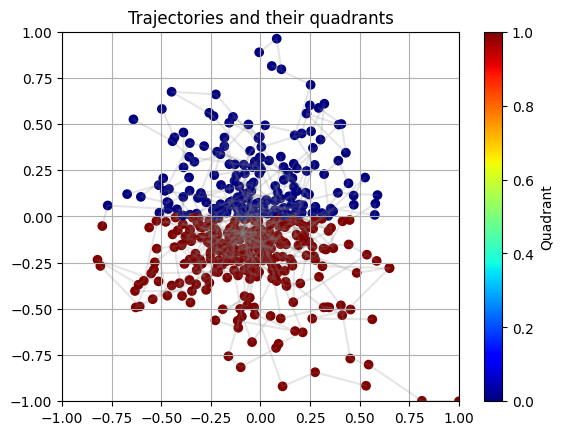

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


def plot_trajectory(X, Y, is_regression=False):
    B, T, _ = X.shape

    if is_regression:
        cmap_name = "gray_r"
        colorbar_label = "Distance from origin"
        title = "Trajectories and their distances from origin"
        norm = Normalize(vmin=Y.min(), vmax=Y.max())
    else:
        cmap_name = "jet"
        colorbar_label = "Quadrant"
        title = "Trajectories and their quadrants"
        norm = Normalize(vmin=Y.min(), vmax=Y.max())

    for b in range(B):
        trajectory = X[b]
        output = Y[b].squeeze()

        plt.scatter(
            trajectory[:, 0],
            trajectory[:, 1],
            c=output,
            marker="o",
            cmap=cmap_name,
            norm=norm,
        )

        plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.2, color="gray")

    plt.colorbar(label=colorbar_label)
    plt.title(title)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.show()


# Hope its clear that we are trying to predict the distance from origin
plot_trajectory(X_test, y_test, is_regression=IS_REGRESSION)

### Exercise

*Observe the scatterplot above. Hypothesize what underlying function would allow us to generate this data. Concretely, write down the mathematical operators (`sin`, `pow`, `exp`, etc.) that would be useful to discover the underlying function.*


<details>
  <summary>Spoiler! Click to see the answer!</summary>
  y is 0 if the point is in the first or second quadrant (where x >= 0), and 1 otherwise. 
</details>


Some useful operators are:
- `mul: (np.array, np.array) -> (np.array)`: Return elementwise multiplication of two arrays of same shape.
- `@TODO`

## Part 2: DSL Generation
Given the following observations, we can conjecture that the DSL will contain the following functions:

* `linear(X) -> Y`: A linear function allows us to express decision boundaries of the form `(a * x) + b > 0` where `a, b` are trainable parameters. We can conjecture that the DSL will contain a linear function that will be used in conjunction with other functions to solve this problem. 
* `map(f, X) -> Y`: `map` is a higher-order function that applies a function `f` to each element of `X`. It will allow us to predict each data point independent of other data points.
* `compose(f, g) -> h`: `compose` is a higher-order function that composes two functions `f` and `g`. It will allow us to combine multiple functions together.
* `output(X) -> Y`: We will need a function that transforms the intermediate output of our program into the final output.
* `if_then_else(cond, then, else) -> Y`: The if-then-else will allow us to reason about discontinuous functions.

Let's also add some extra functions to our DSL:
* `add(X, Y) -> Z`: Implements element-wise addition.
* `mul(X, Y) -> Z`: Implements element-wise multiplication.
* `fold(f, X) -> Y`: `fold` is a higher-order function that applies a function `f` to each element of `X` and accumulates the result. It will allow us to aggregate information from all data points.


- Cell 1: Predefined DSL. 
    - Exercise: Augment the DSL with the operators you wrote down earlier. This is most likely the hardest part of this tutorial!

In [3]:
import torch
import torch.nn as nn

import neurosym as ns
from neurosym.examples import near

def simple_dsl(L, O):
    dslf = ns.DSLFactory(L=L, O=O, max_overall_depth=5)
    dslf.typedef("fL", "{f, $L}")

    dslf.concrete("add", "() -> ($fL, $fL) -> $fL", lambda: lambda x, y: x + y)
    dslf.concrete("mul", "() -> ($fL, $fL) -> $fL", lambda: lambda x, y: x * y)
    dslf.concrete(
        "fold", "((#a, #a) -> #a) -> [#a] -> #a", lambda f: lambda x: near.operations.fold_torch(f, x)
    )
    dslf.concrete(
        "sum", "() -> $fL -> {f, 1}", lambda: lambda x: torch.sum(x, dim=-1).unsqueeze(-1)
    )
    dslf.parameterized(
        "linear", "() -> $fL -> $fL", lambda lin: lin, dict(lin=lambda: nn.Linear(L, L))
    )
    if L != O:
        dslf.parameterized(
            "output",
            "(([$fL]) -> [$fL]) -> [$fL] -> [{f, $O}]",
            lambda f, lin: lambda x: lin(f(x)).softmax(-1),
            dict(lin=lambda: nn.Linear(L, O)),
        )
    else:
        dslf.concrete(
            "output",
            "(([$fL]) -> [$fL]) -> [$fL] -> [{f, $O}]",
            lambda f: lambda x: f(x).softmax(-1),
        )
    dslf.concrete(
        "ite",
        "(#a -> {f, 1}, #a -> #a, #a -> #a) -> #a -> #a",
        lambda cond, fx, fy: near.operations.ite_torch(cond, fx, fy),
    )
    dslf.concrete(
        "map", "(#a -> #b) -> [#a] -> [#b]", lambda f: lambda x: near.operations.map_torch(f, x)
    )

    dslf.concrete(
        "compose", "(#a -> #b, #b -> #c) -> #a -> #c", lambda f, g: lambda x: g(f(x))
    )

    dslf.prune_to("[{f, $L}] -> [{f, $O}]")
    return dslf.finalize()


dsl = simple_dsl(X_test.shape[-1], 2)
print(dsl.render())

            add :: () -> ({f, 2}, {f, 2}) -> {f, 2}
            mul :: () -> ({f, 2}, {f, 2}) -> {f, 2}
           fold :: ((#a, #a) -> #a) -> [#a] -> #a
            sum :: () -> {f, 2} -> {f, 1}
         output :: ([{f, 2}] -> [{f, 2}]) -> [{f, 2}] -> [{f, 2}]
            ite :: (#a -> {f, 1}, #a -> #a, #a -> #a) -> #a -> #a
            map :: (#a -> #b) -> [#a] -> [#b]
      compose_0 :: (#a -> [{f, 2}], [{f, 2}] -> #c) -> #a -> #c
      compose_1 :: (#a -> {f, 2}, {f, 2} -> #c) -> #a -> #c
    linear[lin] :: () -> {f, 2} -> {f, 2}


A couple of things to note:
- _Type Definitions and Tags_: The DSL uses types (e.g., `$fL` for tensors of length `L`) and tags (`#a`, `#b`, `#c`) for type safety.
- _Concrete vs. Parameterized Functions_: The DSL offers fixed-behavior functions (add, mul, etc.) and parametrized ones (linear, output) for flexibility. Any composition of these functions is also differentiable.
 - _Pruning_: The DSL can be pruned with prune_to to restrict to specific function types, optimizing for certain operations.
 
 ### Exercise
*Augment the DSL above with the operators you wrote down earlier.*

## Part 3: Program Generation

[Admissible heuristics](https://en.wikipedia.org/wiki/Admissible_heuristic) are heuristics that never overestimate the cost of reaching a goal. These heuristics can be used as part of an informed search algorithm, such as [A* search](https://en.wikipedia.org/wiki/A*_search_algorithm). Here, we use the assumption that sufficiently large neural networks have greater representational power compared to neurosymbolic models or symbolic models, and use this neural relaxation as an admissible heuristic over the program graph search space.

![img](https://github.com/neurosymbolic-learning/Neurosymbolic_Tutorial/blob/popl23/imgs/admissible.png?raw=true)


Operationally, we will synthesize our program top-down and fill holes with a neural network. To do this, we must first define an extension to our DSL that allows us to specify how to fill holes in our program. We will add the following neural functions to our DSL:

* `MLP(X) -> Y`: A multi-layer perceptron (MLP) that takes in `X` and outputs `Y`.
* `RNN(List[X]) -> List[Y]`: A recurrent neural network (RNN) that takes in a list of `X` and outputs a classification `Y`. This is equvalent to a seq2seq RNN with a single output.

Notice that we add type signatures to each partial program. This ensures that we use a type-appropriate neural network to fill each hole.


- Cell 1: Define a pytorch dataset from the saved data.
- Cell 2: Define `neural_dsl`. This DSL extend the DSL we created with _neural modules_.
- Cell 3: Define optimization functions to train module parameters.
- Cell 4: Define a stopping condition for the search.
- Cell 5: Define the search space and initiate the search.

In [4]:
def dataset_factory(train_seed):
    return ns.DatasetWrapper(
        ns.DatasetFromNpy(
            "../data/classification_example/train_ex_data.npy",
            "../data/classification_example/train_ex_labels.npy",
            train_seed,
        ),
        ns.DatasetFromNpy(
            "../data/classification_example/test_ex_data.npy",
            "../data/classification_example/test_ex_labels.npy",
            None,
        ),
        batch_size=200,
    )


datamodule = dataset_factory(42)
input_dim, output_dim = datamodule.train.get_io_dims()
print(input_dim, output_dim)

2 2


In [5]:
t = ns.TypeDefiner(L=input_dim, O=output_dim)
t.typedef("fL", "{f, $L}")
t.typedef("fO", "{f, $O}")
neural_dsl = near.NeuralDSL.from_dsl(
    dsl=dsl,
    neural_hole_filler=near.UnionNeuralHoleFiller(
        near.create_modules(
            [t("($fL) -> $fL"), t("($fL) -> $fO")],
            near.mlp_factory(hidden_size=10),
        ),
        near.create_modules(
            [t("([$fL]) -> [$fL]"), t("([$fL]) -> [$fO]")],
            near.rnn_factory_seq2seq(hidden_size=10),
        ),
    ),
)

## NEAR with A* Search

We can use NEAR as a heuristic to guide A* search. We maintain a frontier of nodes (starting with an empty program), and at each iteration we choose a node on the frontier to explore by using the NEAR heuristic with a structural cost to estimate its path cost. The search terminates when the frontier is empty, after which we return the best complete program found during our search.

In the code below, we define three functions:

* `classification_cross_entropy_loss` measures the fitness of a program on the validation dataset. This will serve as a way to score partial programs during search.
* `near.near_graph`: This function instantiates the search graph over the space of programs we want to search over.
* `ns.search.bounded_astar`: This function implements a bounded version of the A* algorithm.

Note that each of these functions is independent of the dataset, the DSL, and other functions. This modularity allows us to easily reuse and redefine our synthesis pipeline for different datasets, DSLs, and functions.

In [6]:
pl = ns.import_pytorch_lightning()


def classification_cross_entropy_loss(
    predictions: torch.Tensor, targets: torch.Tensor
) -> torch.Tensor:
    """
    predictions: (B, T, O)
    targets: (B, T, 1)
    """
    targets = targets.squeeze(-1)  # (B, T, 1) -> (B, T)
    assert len(targets.shape) == 2, "Targets must be 2D for classification"
    predictions = predictions.view(-1, predictions.shape[-1])
    targets = targets.view(-1)
    return torch.nn.functional.cross_entropy(predictions, targets)


trainer_cfg = near.NEARTrainerConfig(
    lr=1e-2,
    max_seq_len=100,
    n_epochs=10,
    num_labels=output_dim,
    train_steps=len(datamodule.train),
    loss_callback=classification_cross_entropy_loss,
)

validation_cost = near.ValidationCost(
    trainer_cfg=trainer_cfg,
    neural_dsl=neural_dsl,
    datamodule=datamodule,
    enable_model_summary=False,
    enable_progress_bar=True,
)

In [ ]:
max_depth = 3
g = near.near_graph(
    neural_dsl,
    ns.parse_type(
        s="([{f, $L}]) -> [{f, $O}]", env=ns.TypeDefiner(L=input_dim, O=output_dim)
    ),
    is_goal=lambda _: True,
    max_depth=max_depth
)

iterator = ns.search.bounded_astar(g, validation_cost, max_depth=max_depth)
best_program_node = None
try:
    node = next(iterator)
    cost = validation_cost(node)
    best_program_node = (node, cost)

except StopIteration:
    pass
print("DONE")

## Part 4: Program Inspection

A key benefit of program synthesis is that the output program is interpretable.

- Cell 1: Render the best program.
- Cell 2: Visualize the output space of the best program.
    - Exercise: Does the program discovered line up with your initial hypotheses?

(map (linear))


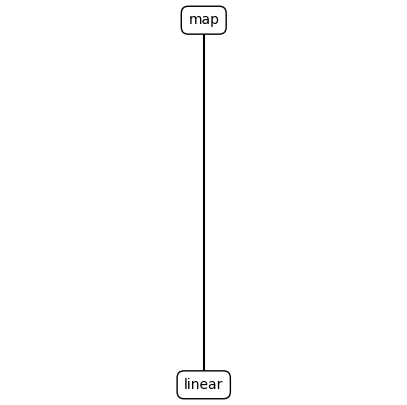

In [8]:
def plot_expression(sexpr, x=0.5, y=1, level=1, dx=0.1, ax=None, text_offset=0.02):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_axis_off()

    ax.text(
        x,
        y,
        sexpr.symbol,
        ha="center",
        va="center",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )

    num_children = len(sexpr.children)
    if num_children > 0:
        child_y = y - 1 / level
        for i, child in enumerate(sexpr.children):
            child_x = x - (dx * (num_children - 1) / 2) + i * dx
            ax.plot([x, child_x], [y - text_offset, child_y + text_offset], "k-")
            plot_expression(
                child,
                x=child_x,
                y=child_y,
                level=level + 1,
                dx=dx / 2,
                ax=ax,
                text_offset=text_offset,
            )

    if ax is None:
        plt.show()


print(ns.render_s_expression(best_program_node[0].program))
plot_expression(best_program_node[0].program)

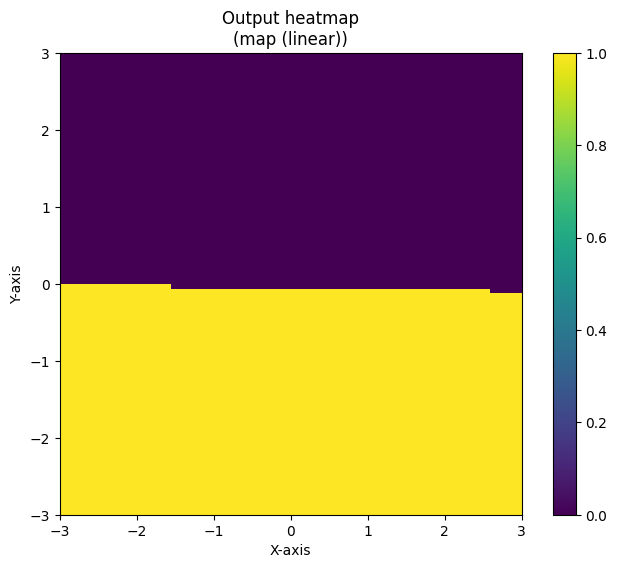

In [9]:
module = near.TorchProgramModule(dsl=neural_dsl, program=best_program_node[0].program)
lin = module.contained_modules[0]
# a satisfactory set of weights. @TODO: Remove
# lin.weight.data = torch.tensor([[0., 1.], [0., 0.]])
# lin.bias.data = torch.tensor([0., 0.])

pl_model = near.NEARTrainer(module, config=trainer_cfg)
trainer = pl.Trainer(
    max_epochs=100,
    devices="auto",
    accelerator="cpu",
    enable_checkpointing=False,
    enable_model_summary=False,
    enable_progress_bar=False,
    logger=False,
    callbacks=[],
)

trainer.fit(pl_model, datamodule.train_dataloader(), datamodule.val_dataloader())

grid = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(grid, grid)

X = np.stack([xx, yy], axis=-1)
X = X.reshape(-1, 2)
X = torch.tensor(X, dtype=torch.float32)
Y = lin(X)
Y = Y.detach().numpy()
Y = Y.reshape(100, 100, 2)
y = Y.argmax(axis=-1)
# Using imshow to plot y as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(
    y, origin="lower", extent=(-3, 3, -3, 3), cmap="viridis"
)  # Choose any colormap that suits your needs
plt.colorbar()
plt.title(
    "Output heatmap\n{program_str}".format(
        program_str=ns.render_s_expression(best_program_node[0].program)
    )
)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

Notice that the output heatmap plots program output within the range `[-3, 3]` while the data we trained on was within the range `[-1, 1]`.

### Exercise
*Does the output heatmap line up with the trajectory data we visualized in part 1? Does the program and the heatmap line up with our initial hypotheses?*